In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler

fnexpr='exprLOW.csv'
fnmet='methylLOW.csv'
fnassig='assignLOW.csv'
nsamp=10000
fnmodel='generator_modelWGANGP6-10K.pth'
filename = "modelfullwgangp6-10K-"

#Función para contar número de parámetros del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
# Definir el generador y el discriminador
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            #nn.Linear(512, 1024),
            #nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        return self.net(x)
        
# Leer datos
expression_data = pd.read_csv(fnexpr)
methylation_data = pd.read_csv(fnmet)
assign_data = pd.read_csv(fnassig)

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
#expression_data.fillna(0, inplace=True)
#methylation_data.fillna(0, inplace=True)
#assign_data.fillna(0, inplace=True)

#Normalizamos
scaler = MinMaxScaler()

# Asumiendo que expression_data, methylation_data y assign_data son tus DataFrames
expression_data_scaled = scaler.fit_transform(expression_data)
methylation_data_scaled = scaler.fit_transform(methylation_data)
assign_data_scaled =assign_data

# Convertir a DataFrame
expression_data = pd.DataFrame(expression_data_scaled, index=expression_data.index, columns=expression_data.columns)
methylation_data = pd.DataFrame(methylation_data_scaled, index=methylation_data.index, columns=methylation_data.columns)
assign_data = pd.DataFrame(assign_data_scaled, index=assign_data.index, columns=assign_data.columns)

#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"

# Convertir a Tensor y pasar a GPU
expression_data = torch.FloatTensor(expression_data.values).to(device)
methylation_data = torch.FloatTensor(methylation_data.values).to(device)
assign_data = torch.FloatTensor(assign_data.values).to(device)
combined_data = torch.cat((expression_data,methylation_data,assign_data), 1).to(device)


True


In [6]:
# Modelos y optimizadores
gen = Generator(100,expression_data.shape[1] + methylation_data.shape[1]+assign_data.shape[1]).to(device)
disc = Discriminator(expression_data.shape[1] + methylation_data.shape[1]+assign_data.shape[1]).to(device)
print(f'El modelo Generator tiene {count_parameters(gen)} parámetros entrenables.')
print(f'El modelo Discriminator tiene {count_parameters(disc)} parámetros entrenables.')
gen_optimizer = optim.RMSprop(gen.parameters(), lr=0.0002)
disc_optimizer = optim.RMSprop(disc.parameters(), lr=0.0002)


# Hiperparámetros adicionales
n_critic = 5 # Número de veces que se actualiza el discriminador por cada actualización del generador
lambda_gp = 10 # Coeficiente de penalización de gradiente

# Función de penalización de gradiente
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calcula la penalización del gradiente para WGAN-GP."""
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1).to(device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# Entrenamiento
n_samples = combined_data.size(0)
batch_size = 64
n_epochs = 10000
start_time = time.time()
for epoch in range(n_epochs):
    for idx in range(0, n_samples, batch_size):
        # Entrenamiento del discriminador
        for nc in range(n_critic):
            real_data = combined_data[idx:idx+batch_size].to(device)
            current_batch_size = real_data.size(0)
           
            disc_optimizer.zero_grad()

            noise = torch.randn(current_batch_size, 100).to(device)
            fake_data = gen(noise).to(device)
            if ((epoch+1) % 100 == 0) and (idx ==0) and (nc==0):
                print(fake_data)
            real_preds = disc(real_data).to(device)
            fake_preds = disc(fake_data).to(device)
            
            # WGAN loss
            d_real_loss = -torch.mean(real_preds)
            d_fake_loss = torch.mean(fake_preds)
            
            gradient_penalty = compute_gradient_penalty(disc, real_data.data, fake_data.data)
            d_loss = d_real_loss + d_fake_loss + lambda_gp * gradient_penalty
            
            d_loss.backward()
            disc_optimizer.step()

        # Entrenamiento del generador
        gen_optimizer.zero_grad()
        
        noise = torch.randn(current_batch_size, 100).to(device)
        fake_data = gen(noise).to(device)
        fake_preds = disc(fake_data).to(device)

        # WGAN loss
        g_loss = -torch.mean(fake_preds)
        
        g_loss.backward()
        gen_optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Disc Loss: {d_loss.item()} | Gen Loss: {g_loss.item()}")
        end_time = time.time()

        # Calcular la diferencia de tiempo
        elapsed_time = end_time - start_time

        print(f"El código tardó {elapsed_time:.5f} segundos en ejecutarse.")
        start_time = time.time()

torch.save(gen.state_dict(), fnmodel)




El modelo Generator tiene 3225075 parámetros entrenables.
El modelo Discriminator tiene 1168385 parámetros entrenables.
tensor([[0.2223, 0.2898, 0.7237,  ..., 0.1499, 0.0492, 1.0000],
        [0.8888, 0.2219, 0.2198,  ..., 0.1576, 0.0782, 1.0000],
        [0.2538, 0.3784, 0.6752,  ..., 0.1828, 0.0454, 1.0000],
        ...,
        [0.8658, 0.5372, 0.1708,  ..., 0.3736, 0.3168, 1.0000],
        [0.2013, 0.5704, 0.7373,  ..., 0.0159, 0.0922, 1.0000],
        [0.1293, 0.7239, 0.8890,  ..., 0.0124, 0.2554, 1.0000]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch 100/10000 | Disc Loss: -0.18918289244174957 | Gen Loss: -0.2872646152973175
El código tardó 522.16918 segundos en ejecutarse.
tensor([[0.4061, 0.5035, 0.5942,  ..., 0.0887, 0.1328, 1.0000],
        [0.8694, 0.4242, 0.1688,  ..., 0.1850, 0.2155, 1.0000],
        [0.2338, 0.4501, 0.7507,  ..., 0.0580, 0.1117, 1.0000],
        ...,
        [0.2030, 0.2411, 0.6821,  ..., 0.1610, 0.1665, 1.0000],
        [0.2208, 0.5141, 0.81

Wasserstein Distance: 0.002620999323856315
KS Statistic: 0.012775100401606454, P-Value: 0.0
Distancia Euclidiana Promedio: 5.430746748843026


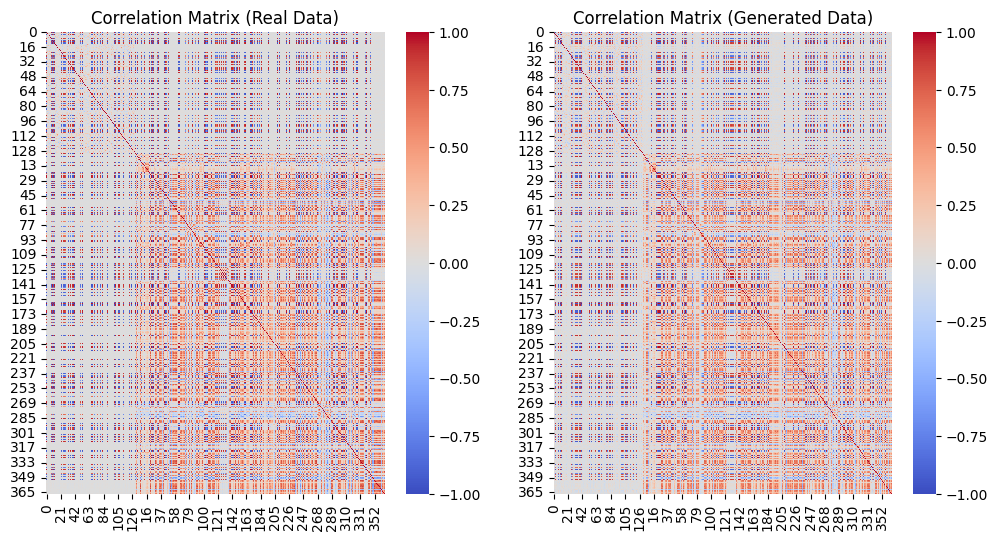

Accuracy: 0.7751666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77      2983
           1       0.77      0.80      0.78      3017

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.78      0.78      0.78      6000



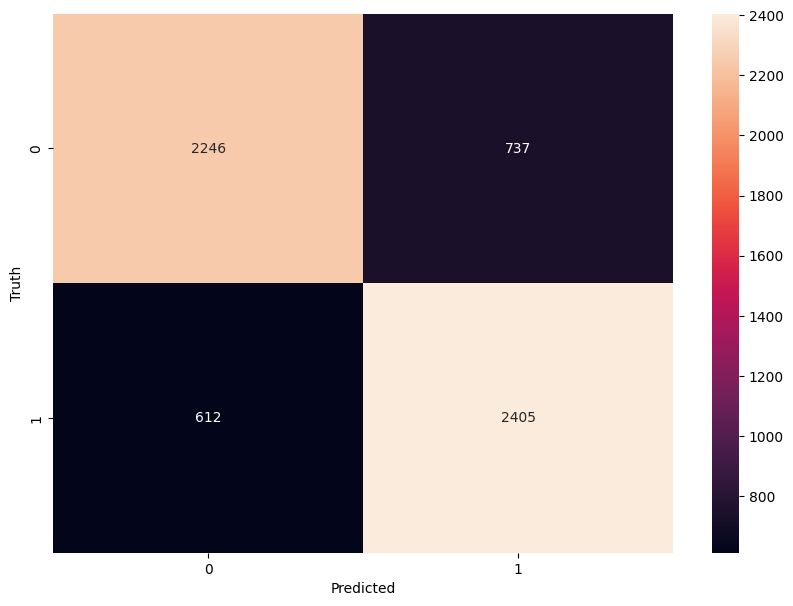

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1925
           1       1.00      0.63      0.78      1075

    accuracy                           0.87      3000
   macro avg       0.91      0.82      0.84      3000
weighted avg       0.89      0.87      0.86      3000



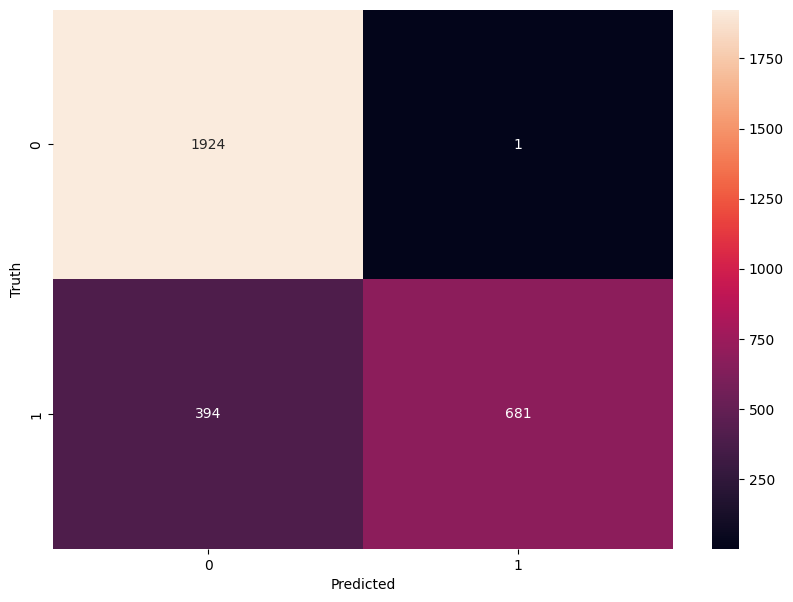

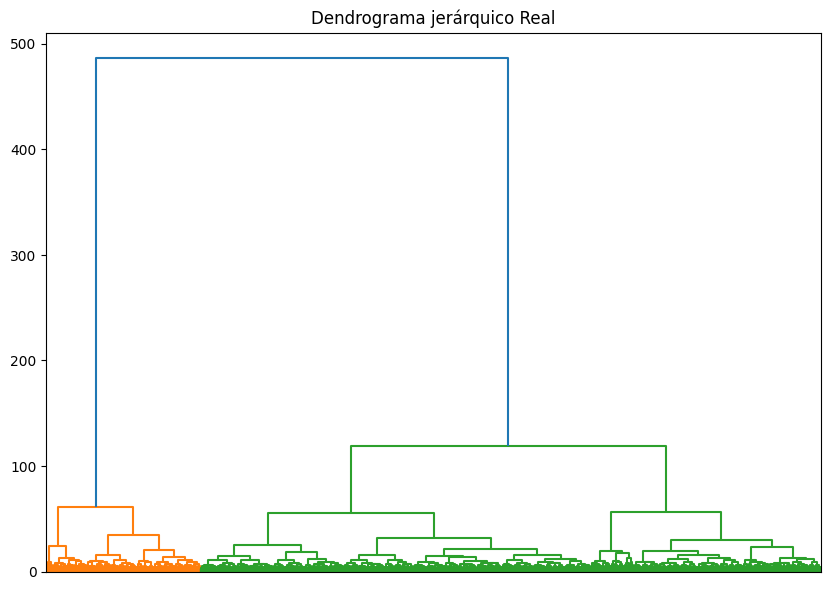

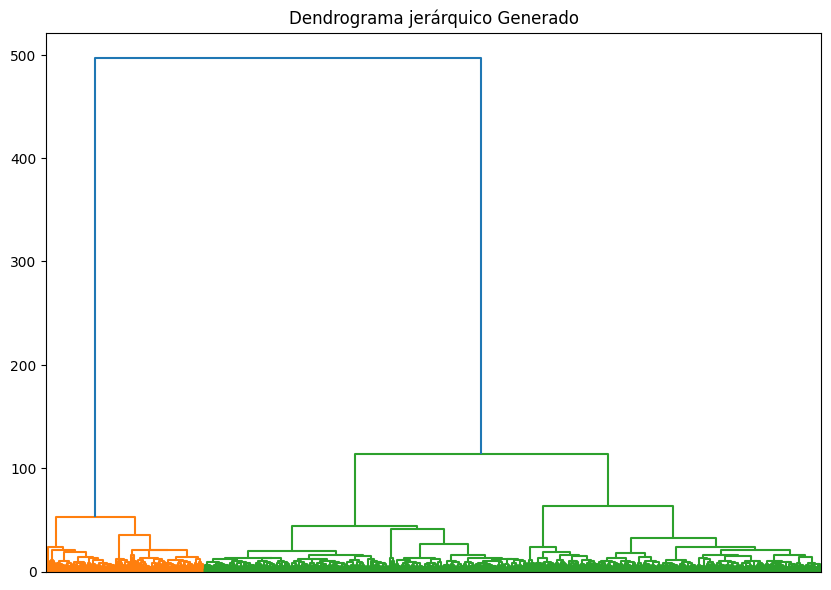

/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


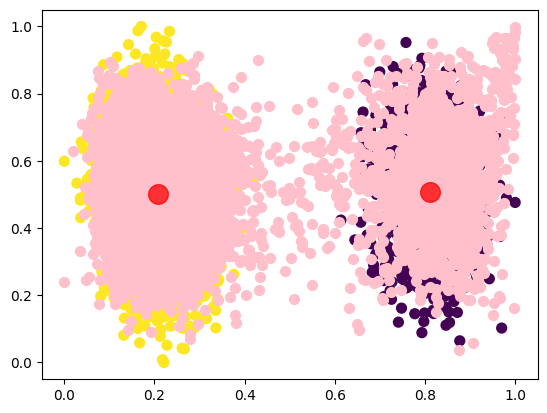

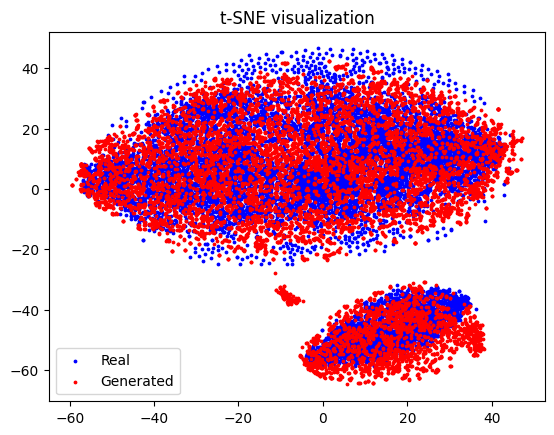

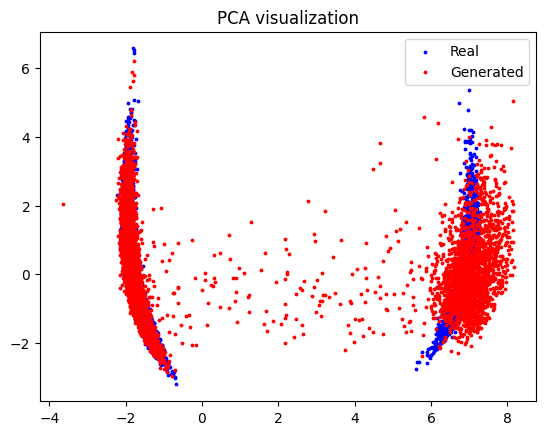

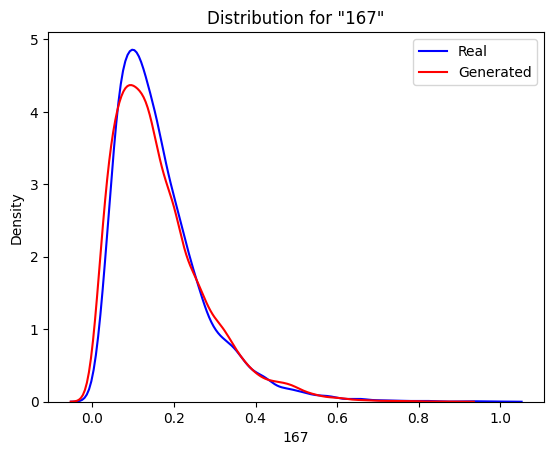

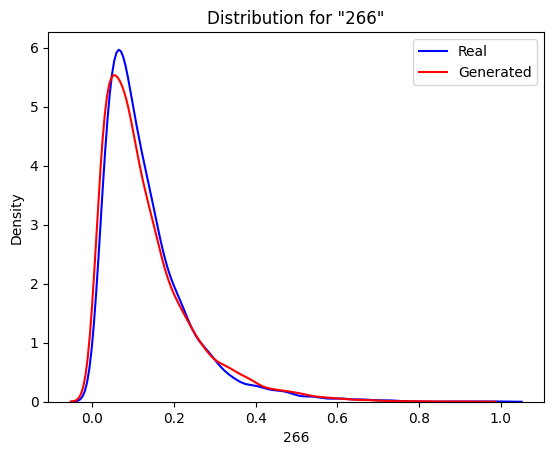

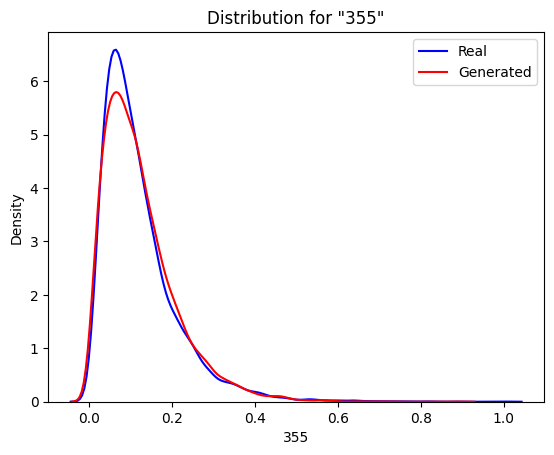

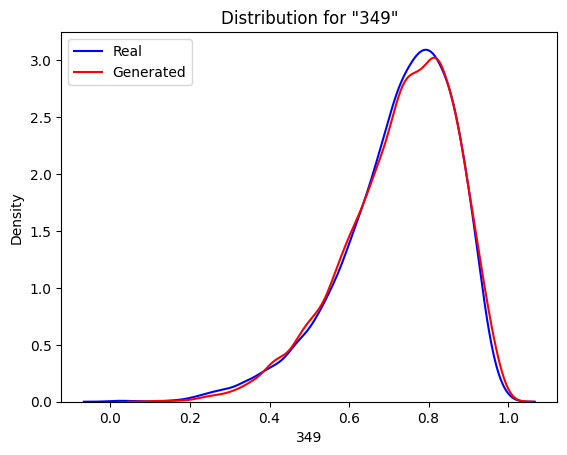

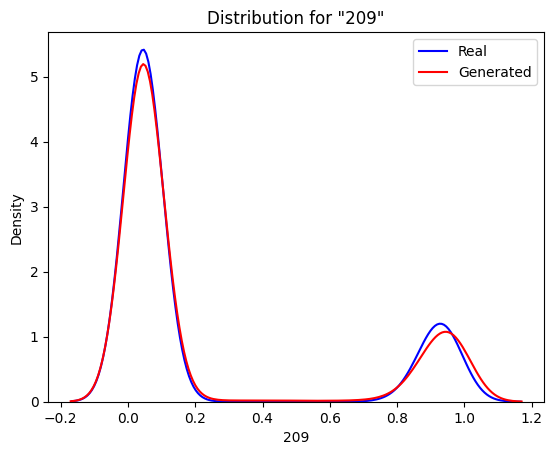

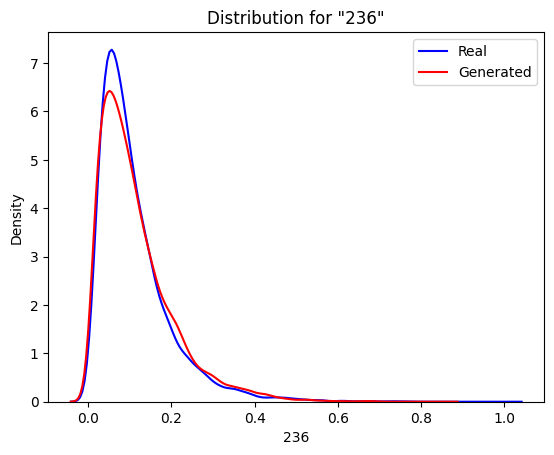

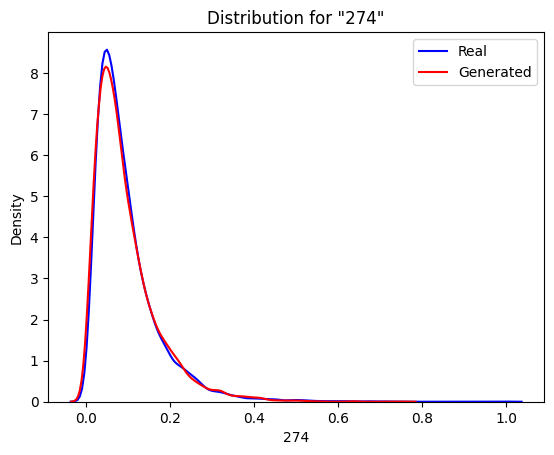

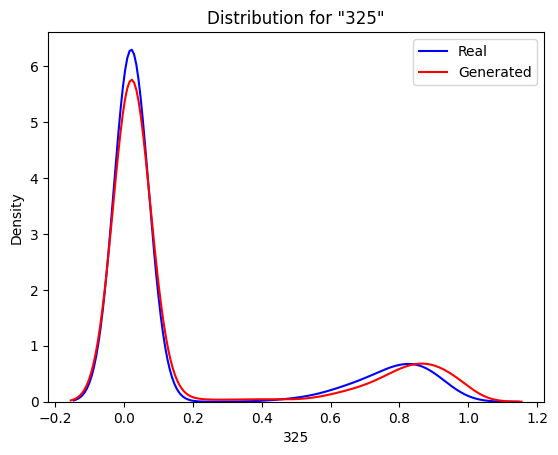

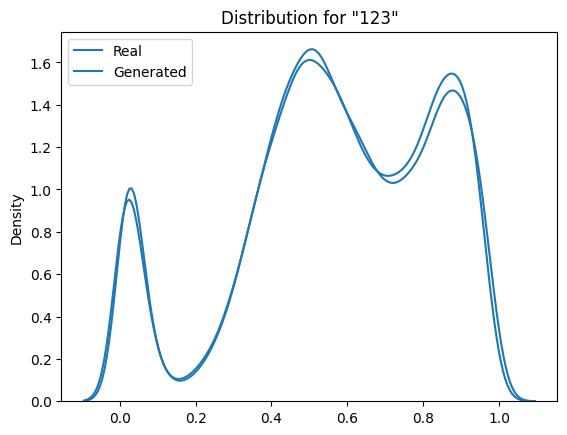

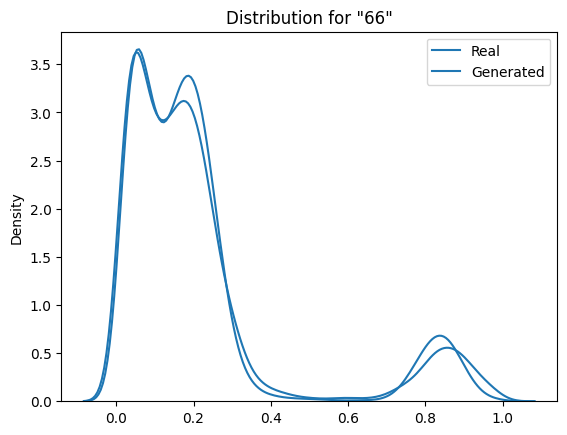

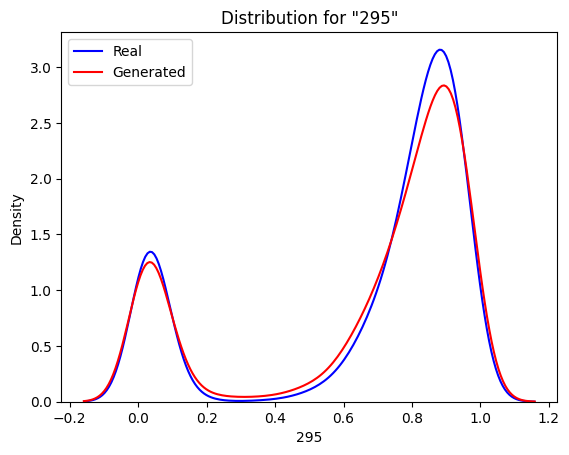

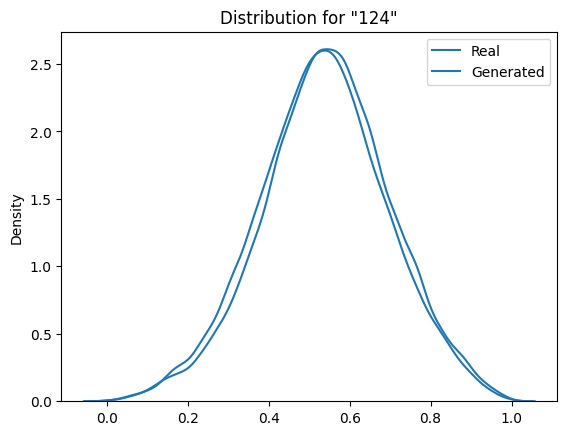

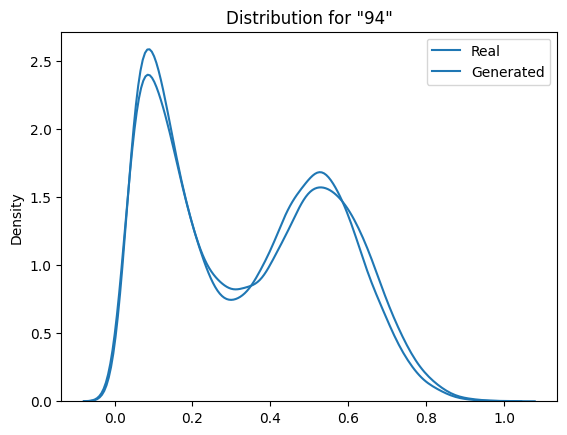

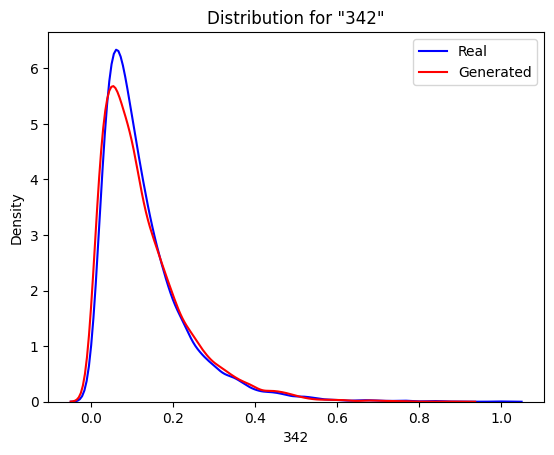

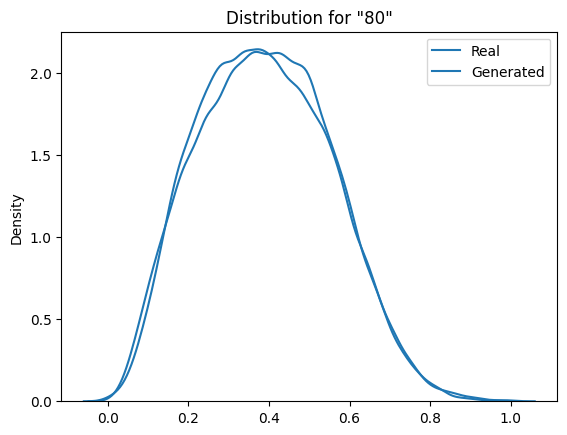

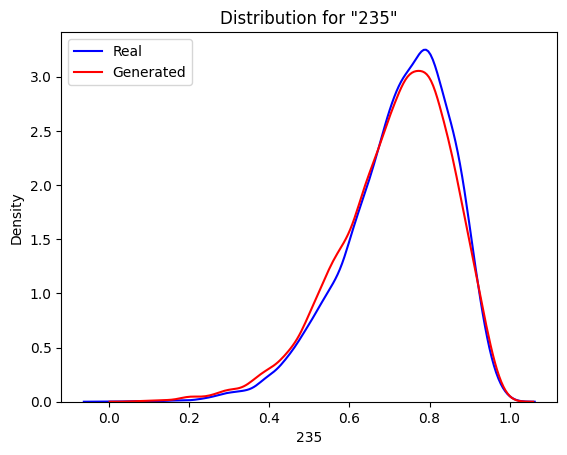

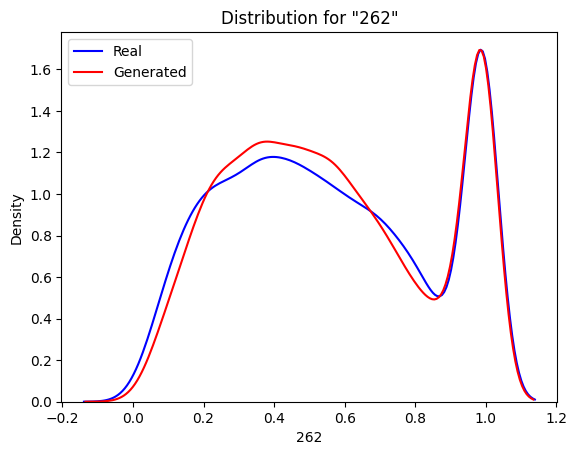

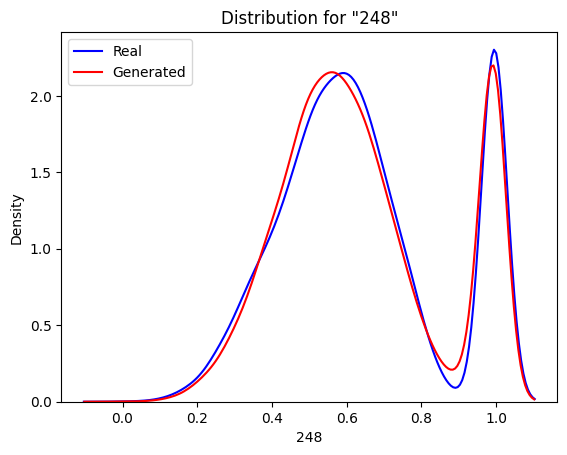

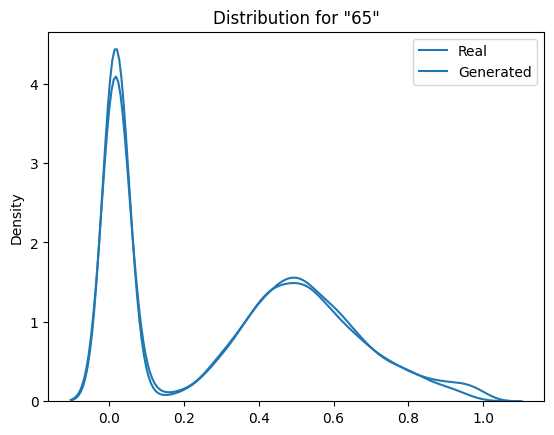

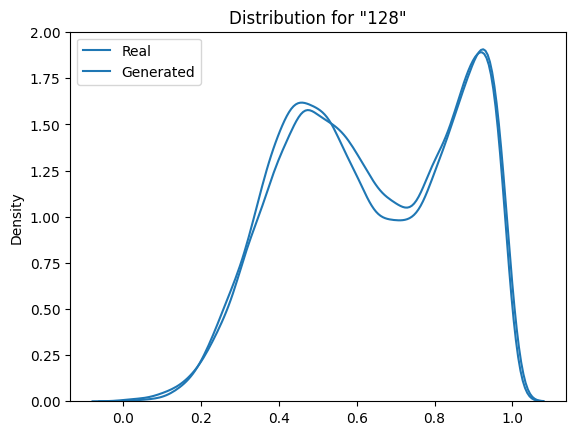

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, ks_2samp
import sys
sys.setrecursionlimit(20000)

# Cargamos los datos
expr_data = pd.read_csv(fnexpr)
meth_data = pd.read_csv(fnmet)
assig_data = pd.read_csv(fnassig)
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0 (CAMBIAR)
#expr_data.fillna(0, inplace=True)
#meth_data.fillna(0, inplace=True)
#assig_data.fillna(0, inplace=True)

#Normalizamos
expr_data = scaler.fit_transform(expr_data)
meth_data = scaler.fit_transform(meth_data)
expr_data = pd.DataFrame(expr_data)
meth_data = pd.DataFrame(meth_data)
assig_data = pd.DataFrame(assig_data)

# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)


# Generar datos de expresión sintética
gen2 = Generator(100, expression_data.shape[1]+methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load(fnmodel))
gen2.eval()
expressions_list = []
for i in range(nsamp):
    noise = torch.randn(1, 100).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X_gan = pd.DataFrame(expressions_list)

y = X_gan.iloc[:, -1].values.astype(int)  # Suponiendo que la asignación está en la primera columna

X = X_gan.iloc[:, :-1]

last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])
X_gan.columns = X_real.columns
# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])


# Aplanar los datos para cálculos estadísticos
real_data_flattened = X_real.values.flatten()
generated_data_flattened = X_gan.values.flatten()

# Wasserstein Distance
w_distance = wasserstein_distance(real_data_flattened, generated_data_flattened)

# KS Test y Wassertein Distance
ks_statistic, ks_pvalue = ks_2samp(real_data_flattened, generated_data_flattened)

print(f"Wasserstein Distance: {w_distance}")
print(f"KS Statistic: {ks_statistic}, P-Value: {ks_pvalue}")


# Distancia Euclidiana
distancias_euclidianas = cdist(X_real, X_gan, metric='euclidean')
distancia_promedio_euclidiana = np.mean(distancias_euclidianas)
print("Distancia Euclidiana Promedio:", distancia_promedio_euclidiana)

# Calcula las matrices de correlación
corr_real = X_real.corr()
corr_gan = X_gan.corr()

# Dibuja las matrices de correlación
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(corr_real, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Real Data)')

plt.subplot(1, 2, 2)
sns.heatmap(corr_gan, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Generated Data)')

plt.show()

# Etiquetas: 1 para real, 0 para generado
y_real = [1] * X_real.shape[0]
y_gan = [0] * X_gan.shape[0]

# Combina los datos y las etiquetas
y_combined = y_real + y_gan

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Inicializa y entrena el clasificador SVC
svc = SVC()
svc.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = svc.predict(X_test)
# Evalúa el rendimiento del clasificador
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(filename+"SVC1.jpg")
plt.show()


# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
unique_classes = np.unique(y_train)
if len(unique_classes) > 1:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.savefig(filename+"SVC2.jpg")
    plt.show()
else:
    print("SVC: Solo una clase")



# Clustering jerárquico
linked1 = linkage(X_real, method='ward')
linked2 = linkage(X_gan, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked1, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Real")
plt.savefig(filename+"DJR.jpg")
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(linked2, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Generado")
plt.savefig(filename+"DJG.jpg")
plt.show()


# K-Means
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_real)
labels = kmeans.predict(X_real)
centroids = kmeans.cluster_centers_
X_array = X_real.values
generated_data=X_gan.values
plt.scatter(X_array[:, 0], X_array[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(generated_data[:, 0], generated_data[:, 1], s=50, color='pink', label='Datos Generados')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75)
plt.savefig(filename+"KNN.jpg")
plt.show()

# Aplicar t-SNE
# Crea etiquetas para los datos (1 para reales, 0 para GAN)
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('t-SNE visualization')
plt.savefig(filename+"tsne.jpg")
plt.show()



#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('PCA visualization')
plt.savefig(filename+"pca.jpg")
plt.show()

#KDE
column_names = X_real.columns.tolist()
random_columns = random.sample(column_names, 20)
for column_name in random_columns:
    sns.kdeplot(X_real[column_name], label='Real',color='blue')
    sns.kdeplot(X_gan[column_name], label='Generated',color='red')
    plt.legend()
    plt.title(f'Distribution for "{column_name}"')
    plt.savefig(f"{filename}kde-{column_name}.jpg")
    plt.show()